In [1]:
import numpy as np  # For numerical operations and array manipulations
import torch  # Core PyTorch library for tensor operations
import torch.nn as nn  # For building neural network layers
import torch.nn.functional as F  # For functional operations like activation functions, loss, etc.
import matplotlib.pyplot as plt  # For visualizing data and results (e.g., PSFs)
import pyzdde.zdde as pyz  # For communicating with Zemax via DDE interface
import os  # For file and path manipulations
from omegaconf import OmegaConf  # For loading and managing YAML/structured configuration files

In [2]:
# Load dataset configuration YAML file as an OmegaConf object
dataset_config = OmegaConf.load('../dataset_config.yaml')

# Load model configuration YAML file as an OmegaConf object
model_config = OmegaConf.load('../model_config.yaml')

# Merge both dataset and model configurations into a single config object
config = OmegaConf.merge(dataset_config, model_config)


In [3]:
# Create a DDE link object to communicate with Zemax via PyZDDE
ln = pyz.createLink()

# Construct the full file path to the Zemax lens file using the config
zfile = os.path.join(ln.zGetPath()[1], 'Sequential', 'Objectives', config['zemax']['lens_file_path'])

# Load the Zemax lens file into the DDE session
ln.zLoadFile(zfile)


0

In [4]:
# Modify FFT PSF settings in Zemax using parameters from the config file
# - settingsFile: path to the configuration file specifying FFT PSF parameters
# - sample: image sampling factor (e.g., 1 for 64x64, 2 for 128x128, etc.)
# Other parameters like dtype, wave, field, etc., use default (None)

ln.zModifyFFTPSFSettings(
    settingsFile = config['zemax']['config_file_path'],
    dtype        = None,
    sample       = config['zemax']['sampling'],
    wave         = None,
    field        = None,
    surf         = None,
    pol          = None,
    norm         = None,
    imgDelta     = None
)


(0,)

In [8]:
def apply_mirror_alignment(
    primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt,
    primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt,
    primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt,
    primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt,
    primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt,
    primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt,
    secondary_mirror_piston, secondary_mirror_tip, secondary_mirror_tilt,
    output_scale='linear', root_n=2):
    """
    Sets piston, tip, and tilt values for all 6 primary mirror segments and the secondary mirror.
    Displays PSF in linear, log, or nth root scale.
    """
    wavelength = 0.632  # um
    
    segment_values = [
        (primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt),
        (primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt),
        (primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt),
        (primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt),
        (primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt),
        (primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt),
    ]
    
    for seg_idx, (piston_lambda, tip_lambda, tilt_lambda) in enumerate(segment_values):
        piston_mm = (piston_lambda / 1000) * wavelength
        tip_deg = np.degrees(np.arctan((wavelength * tip_lambda) / 125180))
        tilt_deg = np.degrees(np.arctan((wavelength * tilt_lambda) / 125180))
        
        print(f"Primary Segment {seg_idx+1}: Piston = {piston_lambda} lambda ({piston_mm} mm), "
              f"Tip = {tip_lambda} lambda ({tip_deg} deg), "
              f"Tilt = {tilt_lambda} lambda ({tilt_deg} deg)")
        
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=3, data=float(piston_mm))
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=4, data=float(tip_deg))
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=5, data=float(tilt_deg))
    
    # Convert secondary mirror values
    sec_piston_mm = (secondary_mirror_piston / 1000) * wavelength
    sec_tip_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tip) / 61000))
    sec_tilt_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tilt) / 61000))
    
    print(f"Secondary Mirror: Piston = {secondary_mirror_piston} lambda ({sec_piston_mm} mm), "
          f"Tip = {secondary_mirror_tip} lambda ({sec_tip_deg} deg), "
          f"Tilt = {secondary_mirror_tilt} lambda ({sec_tilt_deg} deg)")
    
    ln.zSetThickness(surfNum=6, value=float(sec_piston_mm))
    ln.zSetSurfaceParameter(surfNum=6, param=3, value=float(sec_tip_deg))
    ln.zSetSurfaceParameter(surfNum=6, param=4, value=float(sec_tilt_deg))
    
    # Retrieve and return PSF
    psf_list = ln.zGetPSF('fft')[1]
    psf_array = np.array(psf_list)
    
    plt.figure()
    if output_scale == 'log':
        plt.imshow(np.log(psf_array), cmap='gray')
        plt.title("Log Scale PSF Image")
    elif output_scale == 'nth_root':
        plt.imshow(psf_array ** (1 / root_n), cmap='gray')
        plt.title(f"Nth Root Scale PSF Image (n={root_n})")
    else:
        plt.imshow(psf_array, cmap='gray')
        plt.title("Linear Scale PSF Image")
    
    plt.colorbar()
    plt.show()
    
    return psf_array


Primary Segment 1: Piston = 0.65 lambda (0.0004108 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 2: Piston = 0.23 lambda (0.00014536 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 3: Piston = 0.78 lambda (0.00049296 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 4: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 5: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 6: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Secondary Mirror: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)


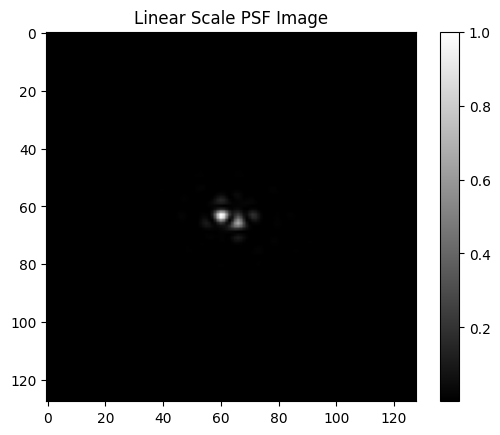

In [10]:
img_nominal = apply_mirror_alignment(
    primary_segment_1_piston= 0.65, primary_segment_1_tip = 0, primary_segment_1_tilt = 0,
    primary_segment_2_piston = 0.23, primary_segment_2_tip = 0, primary_segment_2_tilt = 0,
    primary_segment_3_piston = 0.78, primary_segment_3_tip = 0, primary_segment_3_tilt = 0,
    primary_segment_4_piston = 0, primary_segment_4_tip = 0, primary_segment_4_tilt = 0,
    primary_segment_5_piston = 0, primary_segment_5_tip = 0, primary_segment_5_tilt = 0,
    primary_segment_6_piston = 0, primary_segment_6_tip = 0, primary_segment_6_tilt = 0,
    secondary_mirror_piston = 0, secondary_mirror_tip = 0, secondary_mirror_tilt = 0,
    output_scale='linear', root_n=2)

Primary Segment 1: Piston = 0.65 lambda (0.0004108 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 2: Piston = 0.23 lambda (0.00014536 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 3: Piston = 0.78 lambda (0.00049296 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 4: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 5: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 6: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Secondary Mirror: Piston = 10 lambda (0.00632 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)


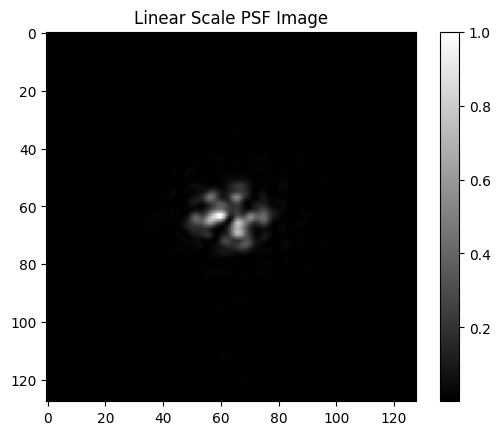

In [11]:
img_defocused = apply_mirror_alignment(
    primary_segment_1_piston= 0.65, primary_segment_1_tip = 0, primary_segment_1_tilt = 0,
    primary_segment_2_piston = 0.23, primary_segment_2_tip = 0, primary_segment_2_tilt = 0,
    primary_segment_3_piston = 0.78, primary_segment_3_tip = 0, primary_segment_3_tilt = 0,
    primary_segment_4_piston = 0, primary_segment_4_tip = 0, primary_segment_4_tilt = 0,
    primary_segment_5_piston = 0, primary_segment_5_tip = 0, primary_segment_5_tilt = 0,
    primary_segment_6_piston = 0, primary_segment_6_tip = 0, primary_segment_6_tilt = 0,
    secondary_mirror_piston = 10, secondary_mirror_tip = 0, secondary_mirror_tilt = 0,
    output_scale='linear', root_n=2)